In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# A special style template for matplotlib, highly useful for visualizing time series data
plt.style.use('fivethirtyeight')
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py # plotly.plotly 패키지는 더 이상 사용되지 않으므로, chart_studio.plotly를 사용함
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm

# Packages for Time Series Analysis
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA

import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Introduction to date and time

## Importing time series data

In [2]:
os.getcwd()

'C:\\Users\\82109\\Desktop\\Data Science\\ML_study\\Kaggle_Dacon\\time_series'

- The required time series column is imported as a datetime column using ```parse_dates``` parameter and is also selected as index of the dataframe using ```index_col``` parameter.
    - ```parse_dates```: 인덱스 열이나 복수 열의 날짜를 파싱할지 여부

In [3]:
google = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', index_col = 'Date', parse_dates = ['Date'])
google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [4]:
google.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


In [5]:
humidity = pd.read_csv('humidity.csv', index_col = 'datetime', parse_dates = ['datetime'])
humidity.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,NaN,81.0,NaN,93.0,24.0,72.0,18.0,68.0,37.0,18.0,...,27.0,NaN,64.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,71.0,NaN,87.0,21.0,72.0,18.0,73.0,34.0,12.0,...,29.0,NaN,59.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,71.0,NaN,93.0,23.0,68.0,17.0,60.0,32.0,15.0,...,31.0,NaN,66.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 23:00:00,NaN,71.0,NaN,87.0,14.0,63.0,17.0,33.0,30.0,28.0,...,26.0,NaN,58.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30 00:00:00,NaN,76.0,NaN,75.0,56.0,72.0,17.0,23.0,34.0,31.0,...,32.0,NaN,58.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
humidity.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45253 entries, 2012-10-01 12:00:00 to 2017-11-30 00:00:00
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Vancouver          43427 non-null  float64
 1   Portland           44804 non-null  float64
 2   San Francisco      44311 non-null  float64
 3   Seattle            44964 non-null  float64
 4   Los Angeles        45101 non-null  float64
 5   San Diego          44909 non-null  float64
 6   Las Vegas          44411 non-null  float64
 7   Phoenix            43945 non-null  float64
 8   Albuquerque        44543 non-null  float64
 9   Denver             43445 non-null  float64
 10  San Antonio        44689 non-null  float64
 11  Dallas             44934 non-null  float64
 12  Houston            45132 non-null  float64
 13  Kansas City        44741 non-null  float64
 14  Minneapolis        44743 non-null  float64
 15  Saint Louis        43964 non-null  

## Cleaning and preparing time series data

- 먼저 각 데이터 셋에 결측치가 존재하는지 확인해보겠다.

In [7]:
google.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [8]:
humidity.isnull().sum()

Vancouver            1826
Portland              449
San Francisco         942
Seattle               289
Los Angeles           152
San Diego             344
Las Vegas             842
Phoenix              1308
Albuquerque           710
Denver               1808
San Antonio           564
Dallas                319
Houston               121
Kansas City           512
Minneapolis           510
Saint Louis          1289
Chicago              1109
Nashville             567
Indianapolis          695
Atlanta               422
Detroit               862
Jacksonville          209
Charlotte             589
Miami                1087
Pittsburgh            522
Toronto               728
Philadelphia          624
New York             1624
Montreal             1696
Boston                449
Beersheba             859
Tel Aviv District    1113
Eilat                 970
Haifa                 818
Nahariyya             817
Jerusalem             906
dtype: int64

- 확인해보니 humidity 데이터 셋에 결측치들이 존재한다.
    - 따라서 **'ffill' 파라미터**를 사용하여 결측치들을 채워주도록 하겠다.
    - **'ffill'** 파라미터에 대한 설명을 아래 이미지로 첨부해두었으니 참고하자.
    
<img src="fillna_ffill.jpg" width="500" height="240" align="left"/>

In [9]:
humidity = humidity.iloc[1:]
humidity = humidity.fillna(method = 'ffill')
humidity.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,62.0,...,71.0,58.0,93.0,68.0,50.0,63.0,22.0,51.0,51.0,50.0
2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,91.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,87.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,62.0,...,69.0,57.0,84.0,68.0,52.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 17:00:00,78.0,79.0,84.0,79.0,88.0,80.0,21.0,24.0,49.0,63.0,...,69.0,57.0,80.0,68.0,54.0,62.0,23.0,51.0,51.0,50.0


## Visualizing the datasets

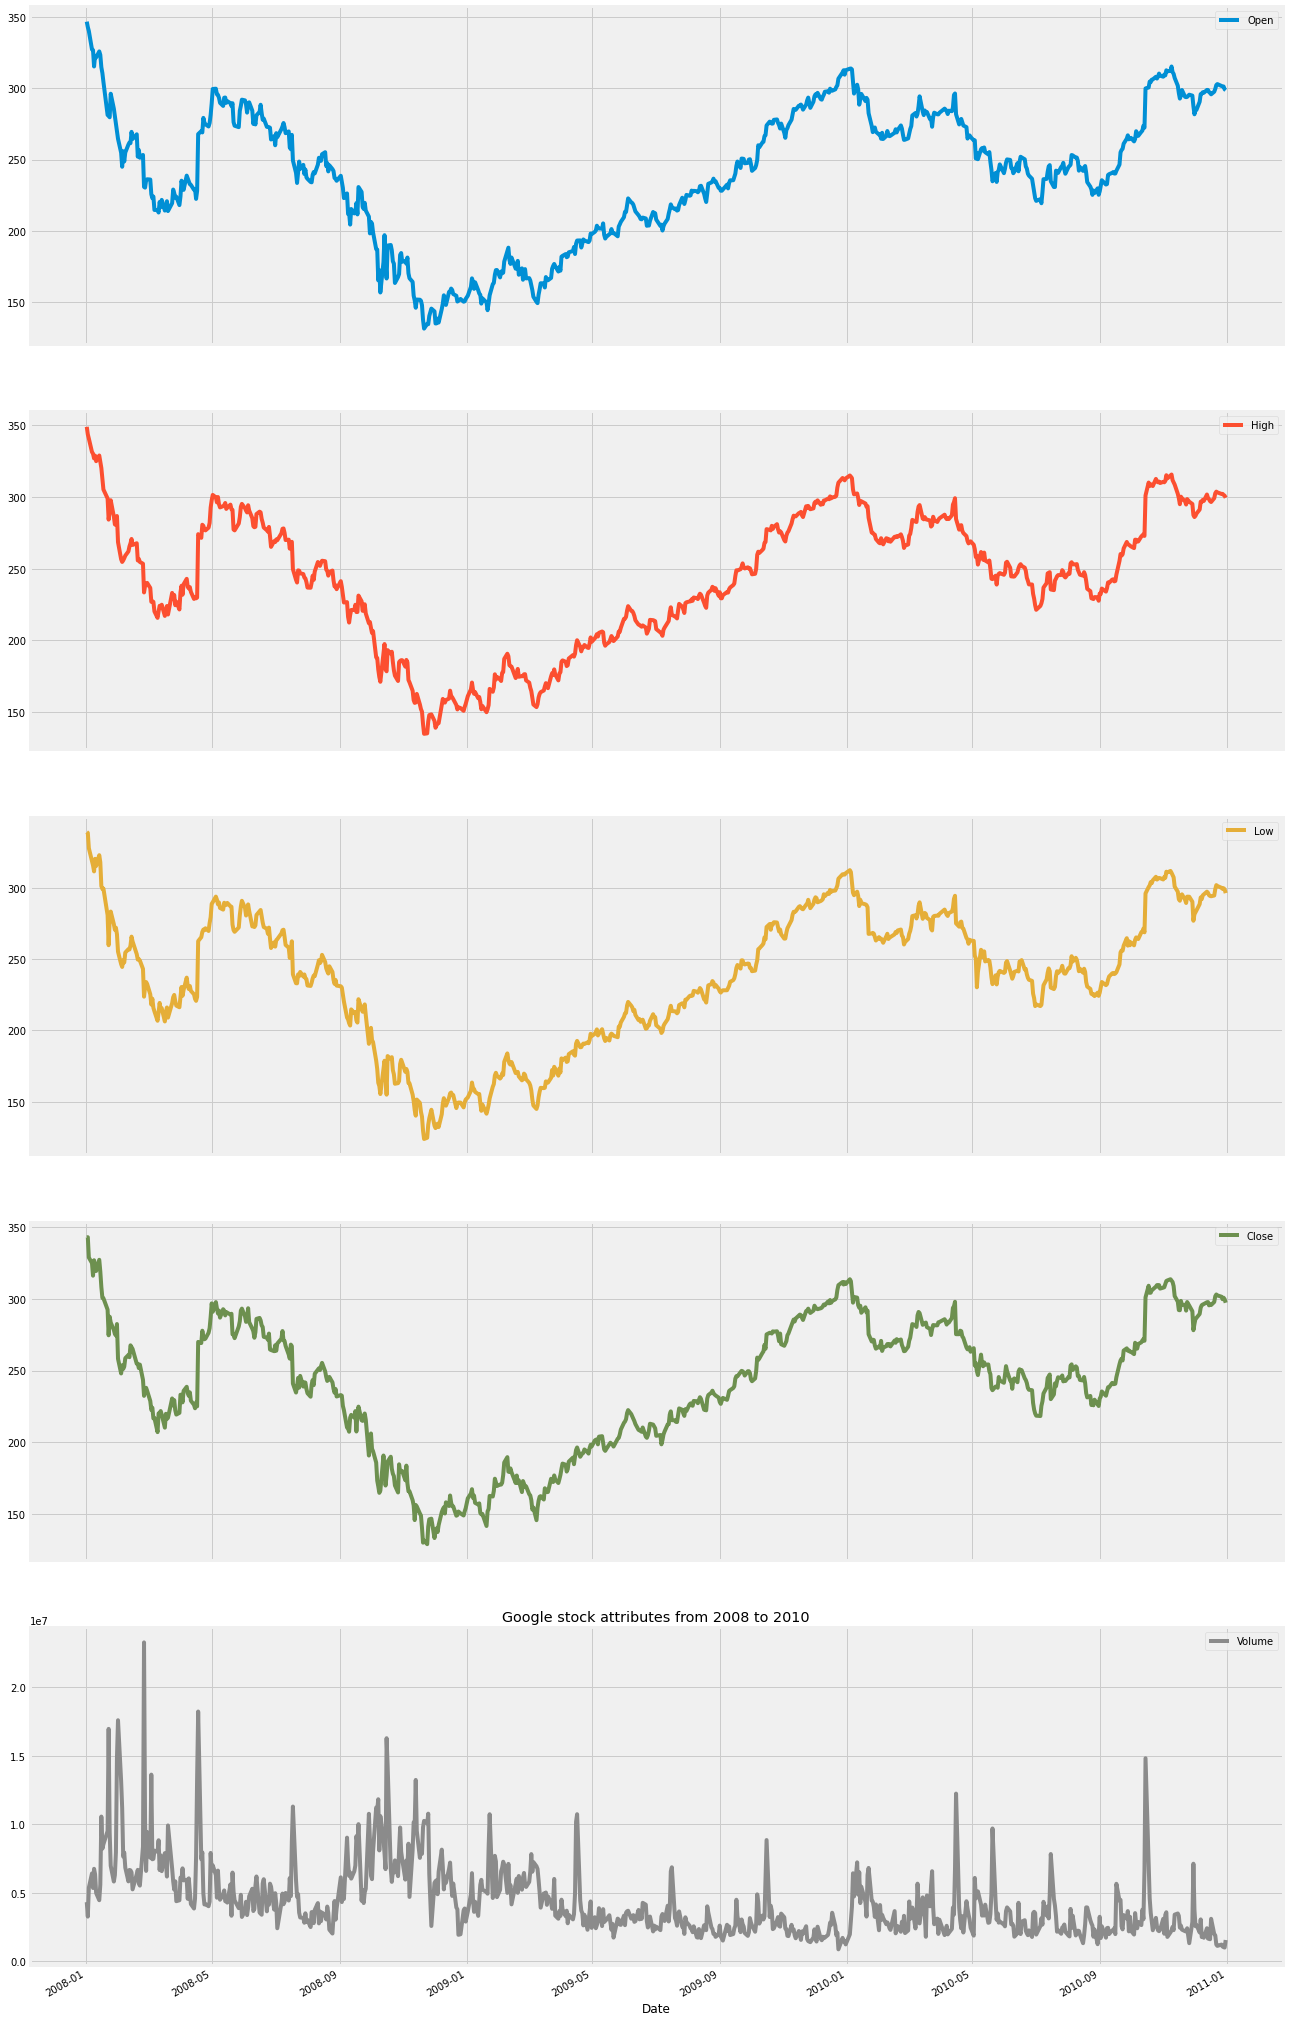

In [10]:
google['2008':'2010'].plot(subplots = True, figsize = (20, 40))
plt.title('Google stock attributes from 2008 to 2010')
plt.show()

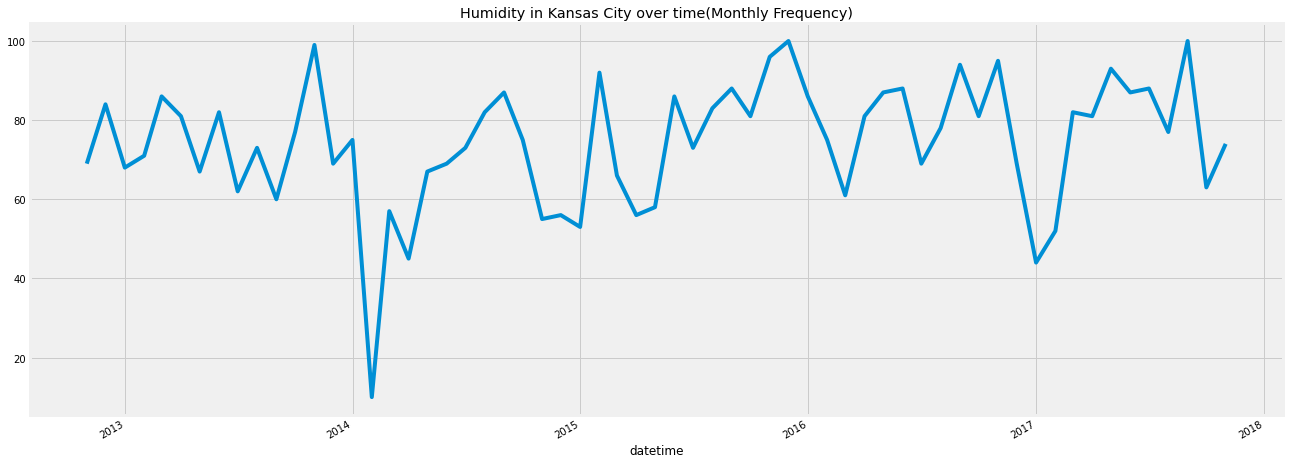

In [11]:
plt.figure(figsize = (20, 8))
# asfreq('M') --> Monthly Frequency
humidity['Kansas City'].asfreq('M').plot()
plt.title('Humidity in Kansas City over time(Monthly Frequency)')
plt.show()

## Timestamps and Periods (연습용 예시)

In [12]:
timestamp = pd.Timestamp(2017, 1, 1, 12) # 해당 시점이 저장됨
timestamp

Timestamp('2017-01-01 12:00:00')

In [13]:
period = pd.Period('2017-01-01') # '2017-01-01' 하루라는 기간을 저장
period

Period('2017-01-01', 'D')

In [14]:
# 해당 period에 timestamp가 존재하는지 확인
period.start_time < timestamp < period.end_time

True

In [15]:
# timestamp를 period로 변환
new_period = timestamp.to_period(freq = 'H')
new_period

Period('2017-01-01 12:00', 'H')

In [16]:
# period를 timestamp로 변환
new_timestamp = period.to_timestamp(freq = 'H', how = 'start')
new_timestamp

Timestamp('2017-01-01 00:00:00')

## Using date_range (연습용 예시)

In [17]:
dr1 = pd.date_range(start = '1/1/18', end = '1/9/18')
dr1

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09'],
              dtype='datetime64[ns]', freq='D')

In [18]:
dr2 = pd.date_range(start = '2018/1/1', end = '2019/1/1', freq = 'M')
dr2

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='M')

In [19]:
dr3 = pd.date_range(end = '2014/1/4', periods = 8)
dr3

DatetimeIndex(['2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04'],
              dtype='datetime64[ns]', freq='D')

In [20]:
dr4 = pd.date_range(start = '2013-04-24', end = '2014-11-27', periods = 3)
dr4

DatetimeIndex(['2013-04-24', '2014-02-09', '2014-11-27'], dtype='datetime64[ns]', freq=None)

## Using to_datetime (연습용 예시)

In [21]:
df = pd.DataFrame({'year':[2015, 2016], 'month':[2, 3], 'day':[4, 5]})
df

,year,month,day
0,2015,2,4
1,2016,3,5


In [22]:
df = pd.to_datetime(df)
df

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]

In [23]:
df = pd.to_datetime('01-01-2017')
df

Timestamp('2017-01-01 00:00:00')

## Shifting and lags

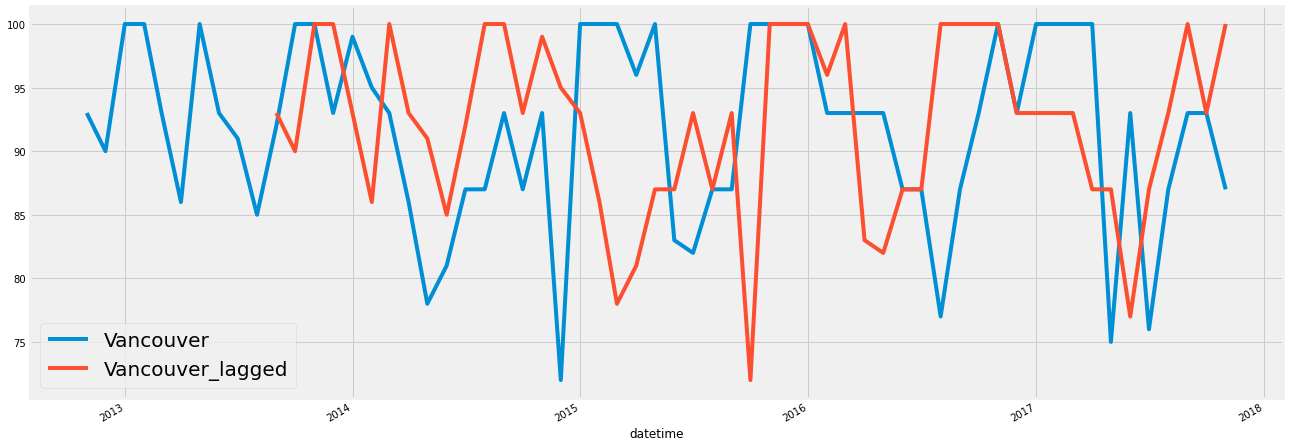

In [24]:
plt.figure(figsize = (20, 8))

humidity['Vancouver'].asfreq('M').plot(legend = True)

# row를 아래로 10줄 shift
# "shift(-10)"라고 설정하면, row를 위로 10줄 shift
shifted = humidity['Vancouver'].asfreq('M').shift(10).plot(legend = True)
shifted.legend(['Vancouver', 'Vancouver_lagged'], fontsize = 20)

plt.show()

## Resampling
- **Upsampling**
    - Time series가 low frequency에서 high frequency로 resampled 된다. **(Monthly to daily frequency)**
    - 누락된 데이터를 채우는 작업
- **Downsampling**
    - Time series가 high frequency에서 low frequency로 resampled 된다. **(Weekly to monthly frequency)**
    - 기존 데이터를 집계하는 작업

In [25]:
pressure = pd.read_csv('pressure.csv', index_col = 'datetime', parse_dates = ['datetime'])
pressure.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,NaN,1031.0,NaN,1030.0,1016.0,1017.0,1021.0,1018.0,1025.0,1016.0,...,1021.0,NaN,1021.0,1017.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,1030.0,NaN,1030.0,1016.0,1017.0,1020.0,1018.0,1024.0,1018.0,...,1021.0,NaN,1023.0,1019.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,1030.0,NaN,1029.0,1015.0,1016.0,1020.0,1017.0,1024.0,1018.0,...,1022.0,NaN,1024.0,1019.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 23:00:00,NaN,1029.0,NaN,1028.0,1016.0,1016.0,1020.0,1016.0,1024.0,1020.0,...,1023.0,NaN,1026.0,1022.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30 00:00:00,NaN,1029.0,NaN,1028.0,1015.0,1017.0,1019.0,1016.0,1024.0,1021.0,...,1024.0,NaN,1027.0,1023.0,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
pressure.isnull().sum()

Vancouver            4234
Portland                4
San Francisco         815
Seattle                13
Los Angeles           252
San Diego             175
Las Vegas              88
Phoenix               594
Albuquerque           456
Denver                543
San Antonio            17
Dallas                 60
Houston                 9
Kansas City           121
Minneapolis            17
Saint Louis            68
Chicago               725
Nashville             147
Indianapolis          289
Atlanta                49
Detroit                 5
Jacksonville           15
Charlotte               3
Miami                 794
Pittsburgh             46
Toronto               175
Philadelphia            4
New York             1041
Montreal              994
Boston                  7
Beersheba             806
Tel Aviv District     930
Eilat                 792
Haifa                 798
Nahariyya             795
Jerusalem             799
dtype: int64

- 확인해보니 pressure 데이터 셋에 많은 결측치들이 존재한다.
    - 따라서 결측치들을 먼저 채워준 뒤, resampling 작업을 수행해주도록 하겠다.
    - 먼저 **'ffill' 파라미터**를 사용하여 **두 번째 row ~ 마지막 row**의 결측치들을 채워주고, **'bfill' 파라미터**를 사용하여 **첫 번째 row**의 결측치들을 채워주도록 하겠다.
    - **'bfill'** 파라미터에 대한 설명을 아래 이미지로 첨부해두었으니 참고하자.
    
<img src="fillna_bfill.jpg" width="500" height="240" align="left"/>

In [27]:
# ffill 파라미터를 사용해서 결측치 채워주기
pressure = pressure.iloc[1:]
pressure = pressure.fillna(method = 'ffill')
pressure.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,1021.0,1031.0,1013.0,1030.0,1016.0,1017.0,1021.0,1018.0,1025.0,1016.0,...,1021.0,1020.0,1021.0,1017.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 21:00:00,1021.0,1030.0,1013.0,1030.0,1016.0,1017.0,1020.0,1018.0,1024.0,1018.0,...,1021.0,1020.0,1023.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 22:00:00,1021.0,1030.0,1013.0,1029.0,1015.0,1016.0,1020.0,1017.0,1024.0,1018.0,...,1022.0,1020.0,1024.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 23:00:00,1021.0,1029.0,1013.0,1028.0,1016.0,1016.0,1020.0,1016.0,1024.0,1020.0,...,1023.0,1020.0,1026.0,1022.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-30 00:00:00,1021.0,1029.0,1013.0,1028.0,1015.0,1017.0,1019.0,1016.0,1024.0,1021.0,...,1024.0,1020.0,1027.0,1023.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0


In [28]:
# 확인해보니 아직 결측치들이 존재함
pressure.isnull().sum().sum()

20

In [29]:
# 다시 한 번 bfill 파라미터를 사용해서 나머지 결측치들을 채워주기
pressure = pressure.fillna(method = 'bfill')
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,1001.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 14:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,986.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 15:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,945.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 16:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,904.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 17:00:00,807.0,1024.0,1009.0,1029.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,863.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0


In [30]:
# 모든 결측치들이 잘 채워졌음!!
pressure.isnull().sum().sum()

0

In [31]:
# Downsampling을 하기 전의 shape 확인
pressure.shape

(45252, 36)

In [32]:
# 평균을 사용하여 hourly에서 3 day frequency aggregated를 downsample 
pressure = pressure.resample('3D').mean()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.000000,1013.000000,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.000000,1013.000000,990.083333
2012-10-07,1013.930556,1017.444444,1016.597222,1018.736111,1013.416667,1014.222222,1012.888889,1011.861111,1005.833333,1020.458333,...,1017.958333,1016.750000,1014.152778,1016.305556,982.972222,1013.027778,1007.555556,1013.000000,1013.000000,989.833333
2012-10-10,1015.000000,1015.430556,1014.833333,1018.416667,1010.694444,1014.013889,1000.166667,1005.611111,986.000000,984.486111,...,1018.694444,1017.916667,1016.166667,1017.319444,979.763889,1006.527778,998.763889,1012.333333,1012.333333,987.888889
2012-10-13,1008.152778,1018.111111,1021.069444,1015.930556,1017.277778,1018.375000,1015.666667,1015.500000,1013.625000,1010.444444,...,1025.055556,1024.388889,1020.805556,1023.736111,984.527778,1013.027778,1007.194444,1013.000000,1013.000000,990.430556


In [33]:
# Downsampling을 한 후의 shape 확인 --> row 개수가 많이 줄어들었음!!
pressure.shape

(629, 36)

In [34]:
# 3 day frequency에서 daily frequency로 upsample
# pad()를 통해 NaN 값들이 채워짐 ('pad'는 'ffill'과 같은 방법임)
pressure = pressure.resample('D').pad()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-02,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-03,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333
2012-10-05,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333


In [35]:
# Upsampling을 한 후의 shape 확인 --> row 개수가 다시 늘어났음!!
pressure.shape

(1885, 36)

# Finance and statistics

## Percent change

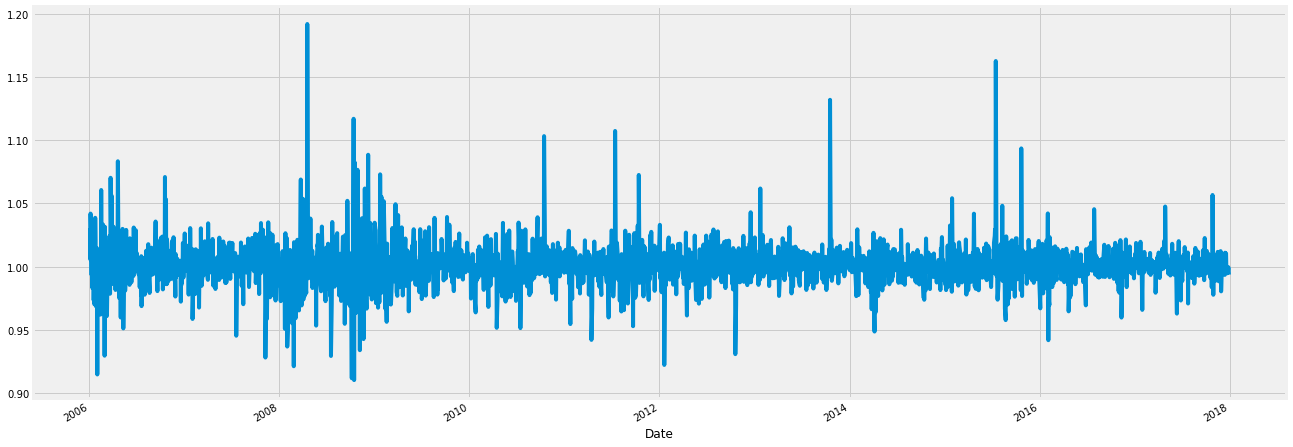

In [36]:
# shift() 함수의 default 값은 "1"임
# 기존의 Hight 변수 값들을 한 줄씩 아래로 shift된 값들로 나눠준 후, 'Change'라는 변수로 지정
google['Change'] = google.High.div(google.High.shift())
google['Change'].plot(figsize = (20, 8))

## Stock returns

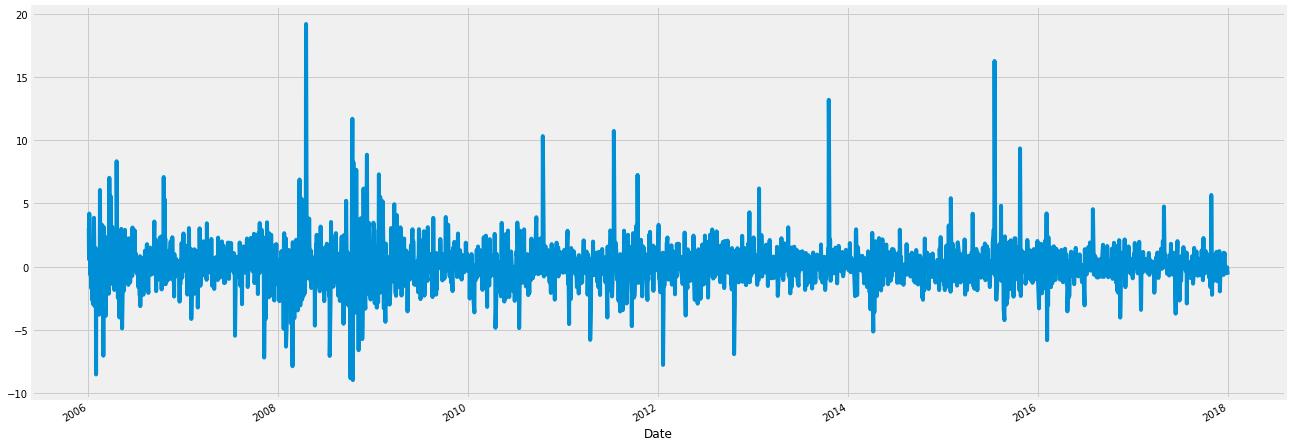

In [37]:
google['Return'] = google.Change.sub(1).mul(100) # (Change - 1) * 100
google['Return'].plot(figsize = (20, 8))

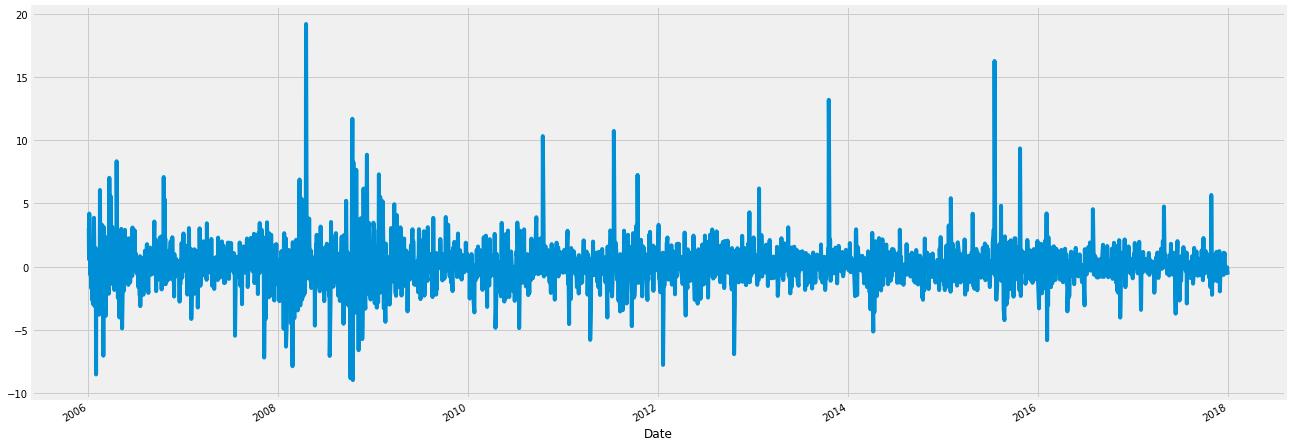

In [38]:
# <참고>
# pct_change()를 사용하면 더 간단하게 위와 동일한 결과를 얻을 수 있음!!
# pct_change(): 퍼센트 변화율 계산
# pct_change()를 사용하면, 전일 또는 어떤 기간에서의 변화율을 퍼센트로 쉽게 계산할 수 있음
google.High.pct_change().mul(100).plot(figsize = (20, 8))

## Absolute change in successive rows

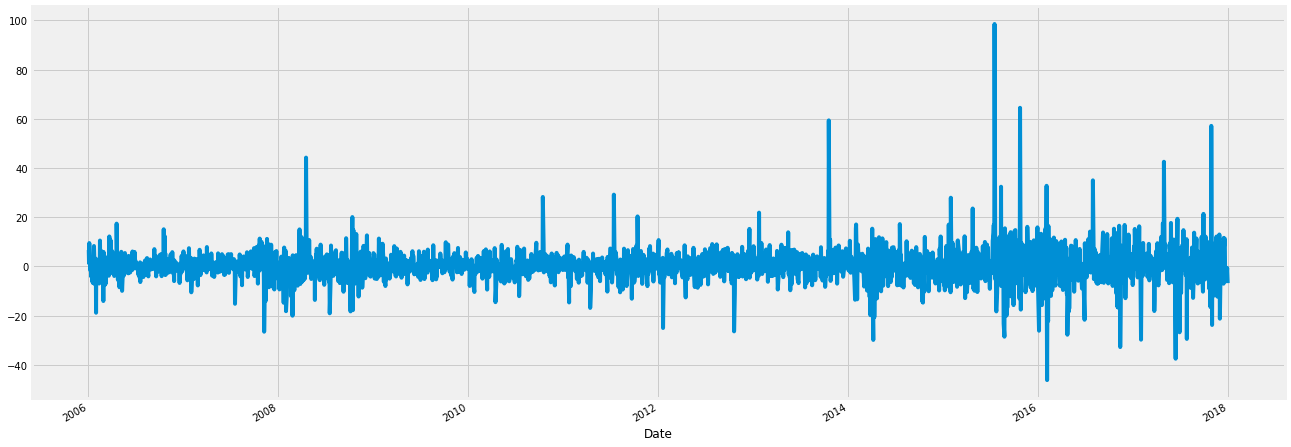

In [39]:
# diff(): Calculate the difference with previous row (default: axis = 0)
google.High.diff().plot(figsize = (20, 8))

## Comparing two or more time series
- 각 time series들을 **normalizing**해서 비교해야 한다.
    - 모든 time series element를 첫 번째 element로 나눠주면 된다.
    - 그러면 두 series가 같은 지점에서 시작되어 쉽게 비교가 가능하다.

In [40]:
microsoft = pd.read_csv('MSFT_2006-01-01_to_2018-01-01.csv', index_col = 'Date', parse_dates = ['Date'])
microsoft.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,26.25,27.00,26.10,26.84,79974418,MSFT
2006-01-04,26.77,27.08,26.77,26.97,57975661,MSFT
2006-01-05,26.96,27.13,26.91,26.99,48247610,MSFT
2006-01-06,26.89,27.00,26.49,26.91,100969092,MSFT
2006-01-09,26.93,27.07,26.76,26.86,55627836,MSFT


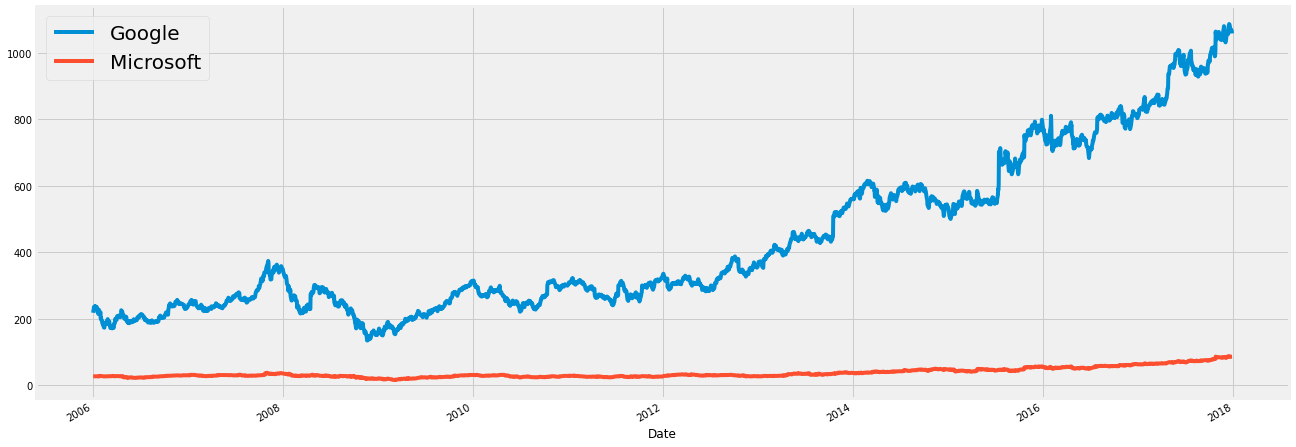

In [41]:
plt.figure(figsize = (20, 8))

google.High.plot()
microsoft.High.plot()

plt.legend(['Google', 'Microsoft'], fontsize = 20)
plt.show()

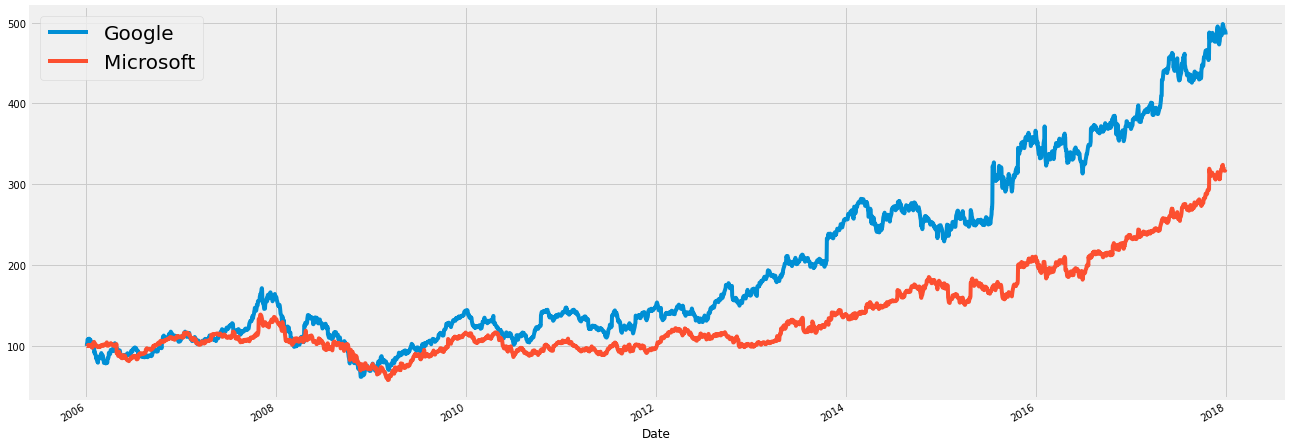

In [42]:
# Normalizing and Comparison
# Both stocks start from 100
normalized_google = google.High.div(google.High.iloc[0]).mul(100)
normalized_microsoft = microsoft.High.div(microsoft.High.iloc[0]).mul(100)

plt.figure(figsize = (20, 8))
normalized_google.plot()
normalized_microsoft.plot()

plt.legend(['Google', 'Microsoft'], fontsize = 20)
plt.show()

## Window functions
- **Window functions**: 행과 행 간의 관계를 쉽게 정의하기 위해 만든 함수
- **Rolling**
    - Rolling Means는 **Moving Averages(이동평균법)**를 뜻하며, 수행 시 plot이 smooth 해진다.
    - Sample size and sliding (동일한 size만큼 옆으로 이동하면서 연산)
    - ex) size가 2라고 평균을 내는 연산을 한다면 (1, 2)의 평균, (2, 3)의 평균, (3, 4)의 평균, ... 이런 식으로 진행된다.
    - 일정 범위에서 동일한 연산을 할 때 유용하다.
- **Expanding**
    - Contains all prior values (size를 키워가며 연산)
    - ex) (1, 2)의 평균, (1, 2, 3)의 평균, (1, 2, 3, 4)의 평균, ... 이런 식으로 진행된다.
    
<참고>
- The difference between the expanding and rolling window
    - https://www.mikulskibartosz.name/the-difference-between-the-expanding-and-rolling-window-in-pandas/

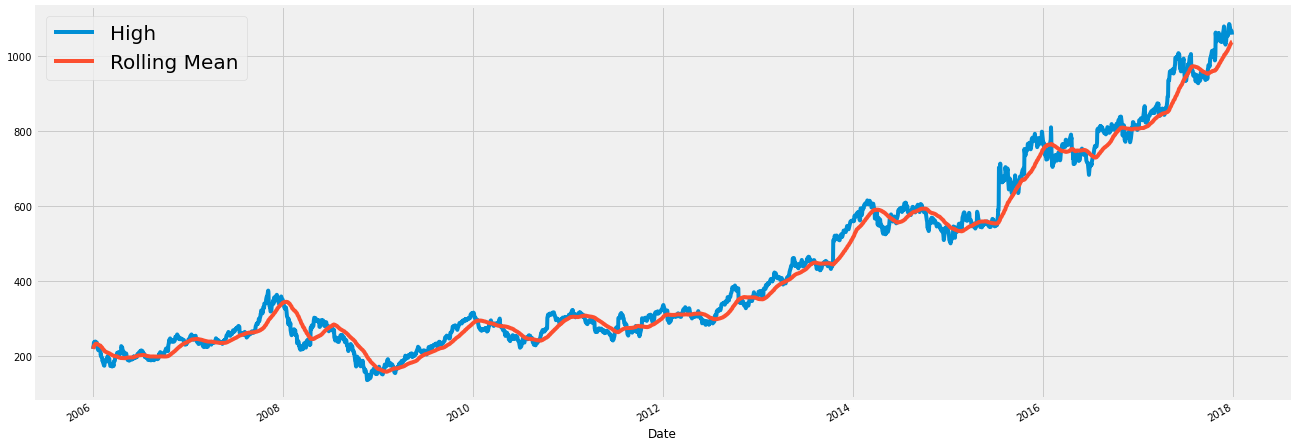

In [43]:
# Rolling window functions
rolling_google = google.High.rolling('90D').mean() # 순차적으로 90 day씩 평균을 냄

plt.figure(figsize = (20, 8))
google.High.plot()
rolling_google.plot()

plt.legend(['High', 'Rolling Mean'], fontsize = 20)
plt.show()

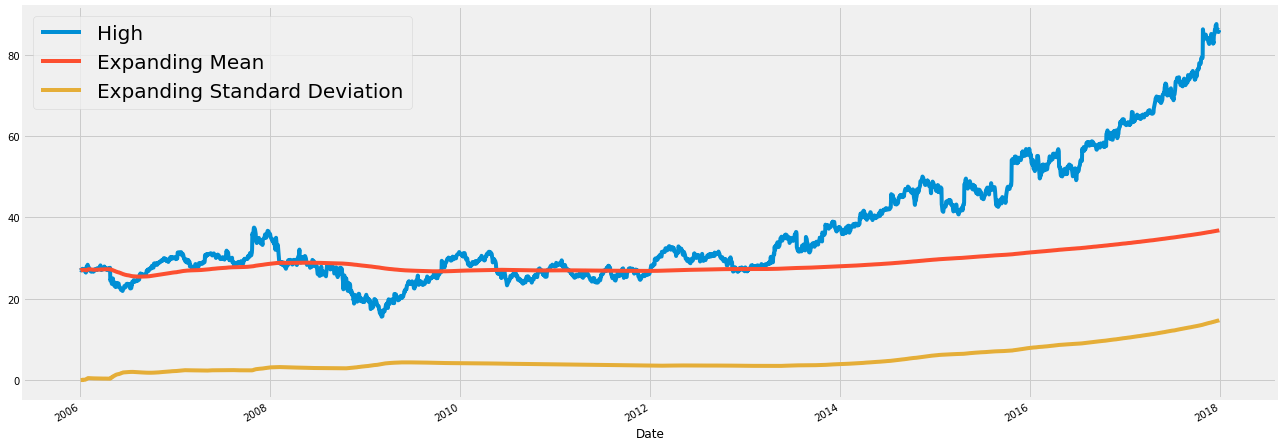

In [44]:
# Expanding window functions
microsoft_mean = microsoft.High.expanding().mean()
microsoft_std = microsoft.High.expanding().std()

plt.figure(figsize = (20, 8))
microsoft.High.plot()
microsoft_mean.plot()
microsoft_std.plot()

plt.legend(['High', 'Expanding Mean', 'Expanding Standard Deviation'], fontsize = 20)
plt.show()

## Autocorrelation and Partial Autocorrelation
- **자기상관(Autocorrelation)**
    - 회귀분석에서 오차항의 가정 중 하나인 **"독립성" 가정이 깨진 경우**, **자기상관이 존재**한다고 말할 수 있다.
        - **Durbin-Watson 검정**을 통해 자기상관성을 검정할 수 있다.
            - Durbin-Watson 검정통계량 d 값은 **0 ~ 4 사이의 값**을 갖는다.
            - **d 값이 2에 가까울수록 자기상관이 존재하지 않는다**고 할 수 있다(즉, **"독립성" 가정 만족**)
    - **ACF(자기상관함수)**의 형태를 보고 **차분 여부 및 시계열 모델(ARIMA)의 모수를 결정**한다. (일반적으로 ACF와 PACF를 같이 확인해서 ARIMA 모델의 모수를 결정한다)
- **편자기상관 또는 부분자기상관(Partial Autocorrelation)**
    - **PACF(편자기상관함수)**의 형태를 보고 **차분 여부 및 시계열 모델(ARIMA)의 모수를 결정**한다. (일반적으로 ACF와 PACF를 같이 확인해서 ARIMA 모델의 모수를 결정한다)

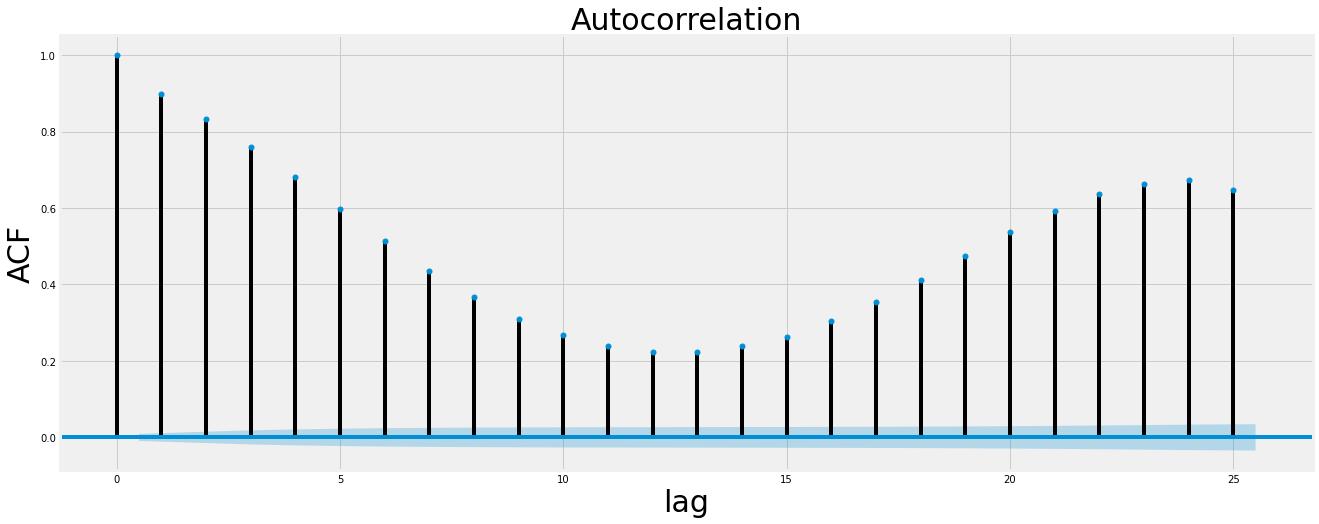

In [45]:
# ACF of humidity of San Diego
fig, ax = plt.subplots(figsize = (20, 8))
plot_acf(humidity['San Diego'], lags = 25, ax = ax)
plt.xlabel('lag', fontsize = 30)
plt.ylabel('ACF', fontsize = 30)
plt.title('Autocorrelation', fontsize = 30)
plt.show()

- 위의 ACF를 보면, 모두 파란 선 바깥쪽에 위치함을 알 수 있다. (즉, 통계적으로 유의하지 않다)
    - 파란 선 밖으로 넘어가면 유의수준 5%(default) 하에서 유의하다고 할 수 있다.
- ACF를 통해 **MA(q)에서 q의 값을 추정**할 수 있다.

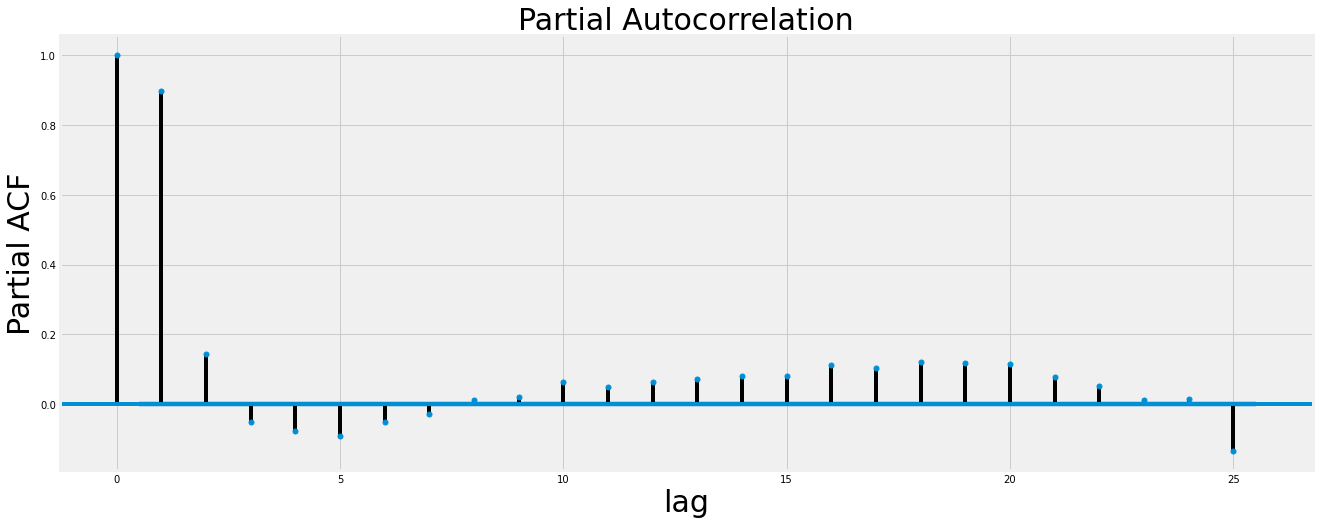

In [46]:
# PACF of humidity of San Diego
fig, ax = plt.subplots(figsize = (20, 8))
plot_pacf(humidity['San Diego'], lags = 25, ax = ax)
plt.xlabel('lag', fontsize = 30)
plt.ylabel('Partial ACF', fontsize = 30)
plt.title('Partial Autocorrelation', fontsize = 30)
plt.show()

- 위의 PACF를 살펴보면, lag = 3에서 절단됨을 알 수 있다.
- PACF를 통해 **AR(p)에서 p의 값을 추정**할 수 있다.

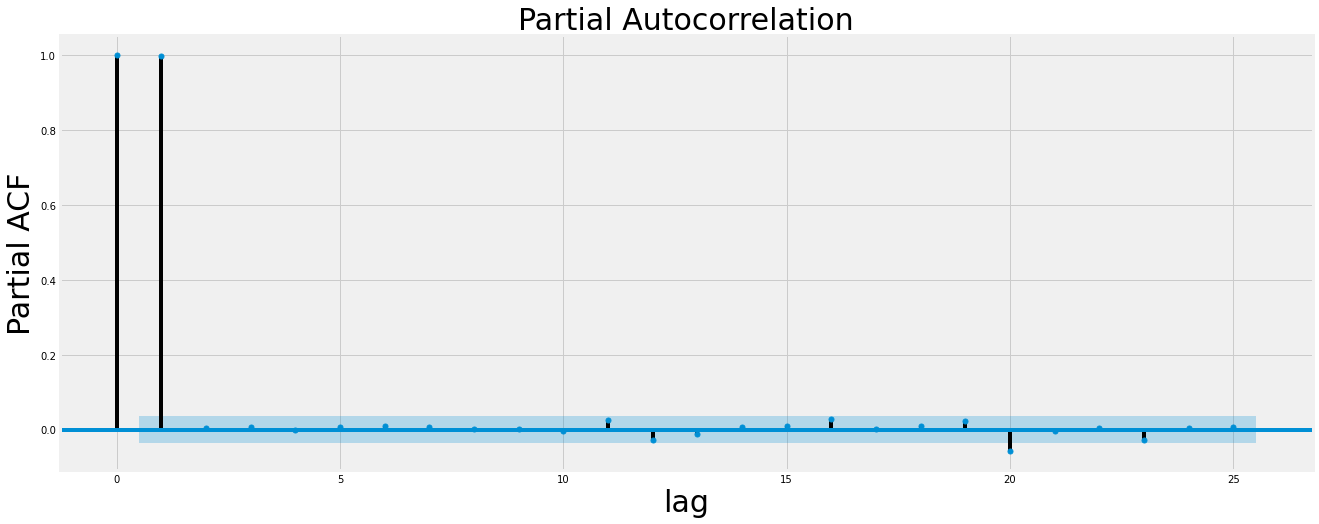

In [47]:
# PACF of closing price of microsoft stocks
fig, ax = plt.subplots(figsize = (20, 8))
plot_pacf(microsoft['Close'], lags = 25, ax = ax)
plt.xlabel('lag', fontsize = 30)
plt.ylabel('Partial ACF', fontsize = 30)
plt.title('Partial Autocorrelation', fontsize = 30)
plt.show()

- 위의 PACF를 보면, lag = 0, 1, 20에서만 통계적으로 유의함을 알 수 있다. (유의수준 5% 하에서 - default)

# Time series decomposition and Random walks

## Trends, seasonality and noise
- **Trend**: 추세 (증가하는 추세인지 감소하는 추세인지)
- **Seasonality**: 계절성 (주기적인 패턴이 존재하는지)
- **Noise**: 이상치 또는 결측치

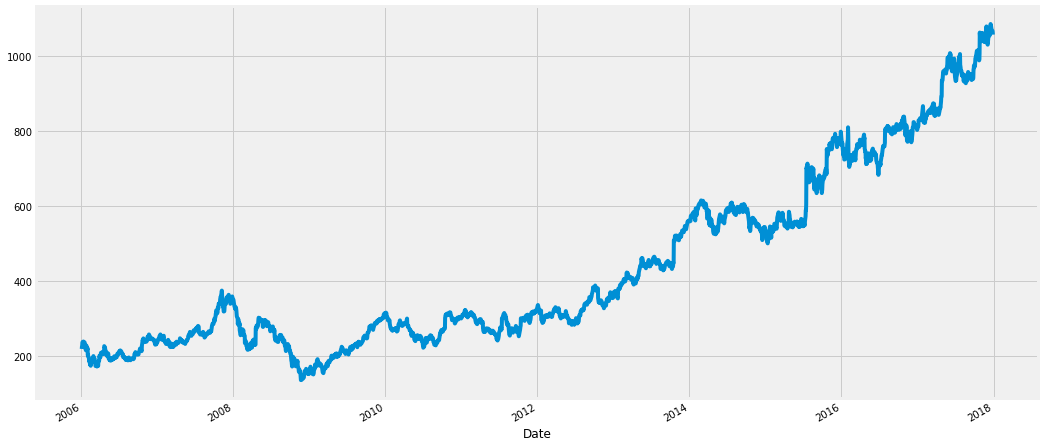

In [48]:
# Google stock 'High' 변수
google['High'].plot(figsize = (16, 8))

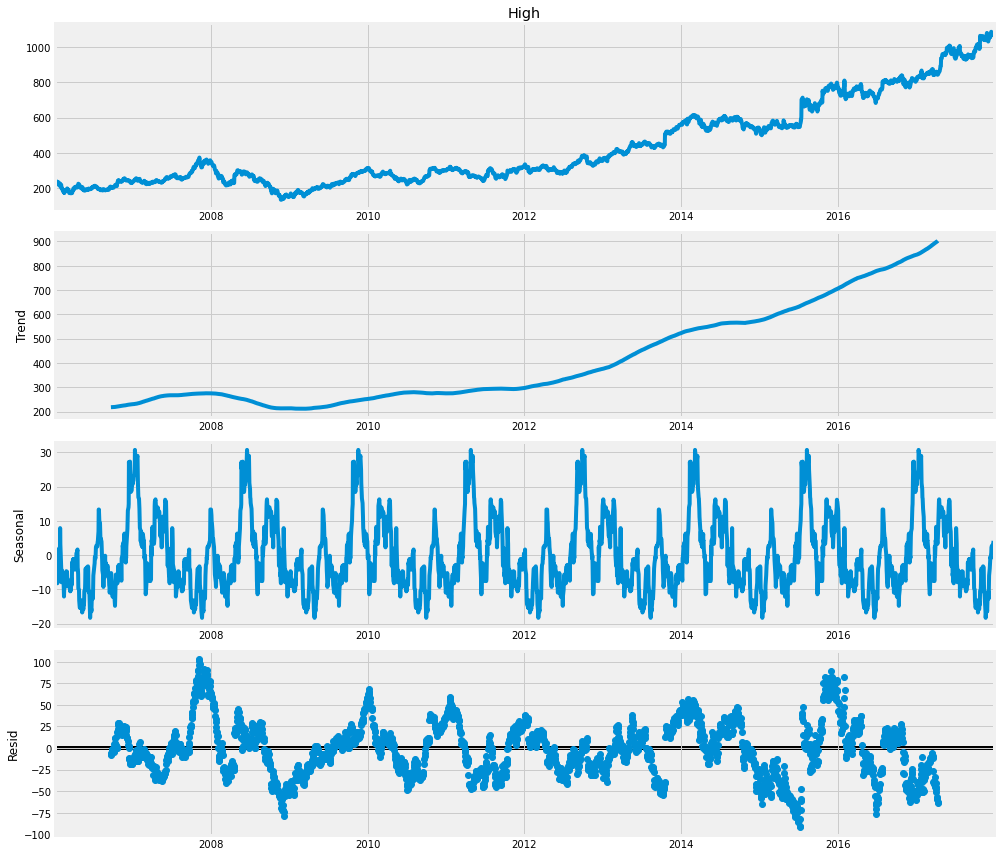

In [49]:
# 시계열 분해 - Decomposition
rcParams['figure.figsize'] = 14, 12

decomposed_google_volume = sm.tsa.seasonal_decompose(google['High'], freq = 360) # 1년 주기
figure = decomposed_google_volume.plot()
plt.show()

**<시계열 분해 결과 해석>**
- **Trend**
    - 전반적으로 증가하는 추세를 보인다.
- **Seasonality**
    - 일정한 주기로 패턴(계절성)도 보인다.
- **Residual(잔차 = 불규칙 요인)**
    - 시계열 분해 후의 추세와 계절성을 제외한 잔차(residual, random/irregular factor)가 특정 패턴 없이 무작위 분포를 띠고 작은 값이면, 추세와 계절성으로 모형화가 잘 되는 것이고 시계열 자료의 특성을 이해하고 예측하는데 활용할 수 있다.
    - 만약 시계열 분해 후의 잔차에 특정 패턴(ex.**주기적인 파동을 그린다**거나, **분산이 점점 커진다**거나 등)이 존재한다면, 잔차에 대해서만 다른 모형을 추가로 적합할 수도 있다.
- **추세(trend)와 계절성(seasonality)이 존재**하므로, **비정상 시계열**임을 알 수 있다.
    - 일반적으로 "정상성(stationarity)"은 "엄격한 의미의 정상성"이 아닌 **"약한 정상성"**을 의미하며, 시계열의 확률적인 성질들이 시간의 흐름에 따라 변하지 않는다는 것을 의미한다.
        - 즉, **뚜렷한 추세가 없으며, 시계열의 변동이 시간의 흐름에 따라 일정(분산이 일정)**하다.
    - **대부분의 시계열 이론은 정상성을 가정**하기 때문에, **비정상 시계열을 정상 시계열로 변환**해주는 것은 굉장히 중요한 작업이다!!
        - **차분(difference)**을 통해 정상성을 띠도록 변환해 줄 수 있다.
        - 단, 일반적으로 **차분 횟수는 1 ~ 2번 정도가 적당**하다.
        
<참고 자료>
- 시계열 정상성: https://m.blog.naver.com/PostView.nhn?blogId=muzzincys&logNo=220077613384&proxyReferer=https:%2F%2Fwww.google.com%2F

**<단위근 검정(Unit Root Test)>**
- 단위근 존재 여부 확인을 위해, google stock 데이터 셋의 'High' 변수에 대해서 **단위근 검정**을 수행해보았다.
    - 단위근 검정 결과, 유의수준 5% 하에서 귀무가설을 기각하지 못하므로 단위근이 존재한다고 할 만한 충분한 근거가 있다고 할 수 있다. (즉, 비정상 시계열이라고 판단할 충분한 근거가 있다)

In [50]:
# Dickey-Fuller Test(= 단위근 검정)
# 귀무가설: 단위근이 존재한다. (즉, 비정상 시계열 = Random walk)
adf = adfuller(google['High'])
print("p-value of google: {}".format(float(adf[1])))

p-value of google: 0.9956341649311281


- 따라서 비정상 시계열 자료를 정상 시계열 자료로 변환해주기 위해 차분(difference)을 해주겠다.

Text(0, 0.5, 'High')

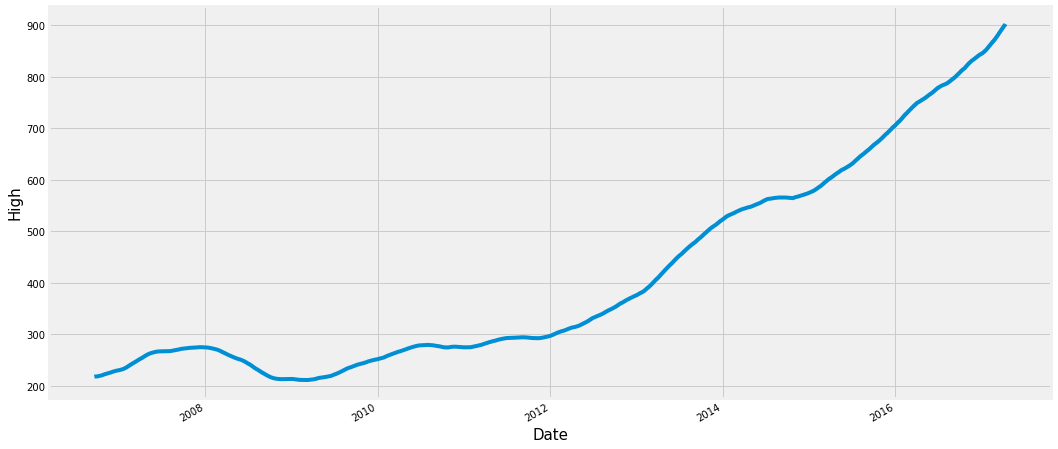

In [51]:
plt.figure(figsize = (16, 8))
decomposed_google_volume.trend.plot()
plt.xlabel('Date', fontsize = 15)
plt.ylabel('High', fontsize = 15)

Text(0, 0.5, '1st_diff_of_High')

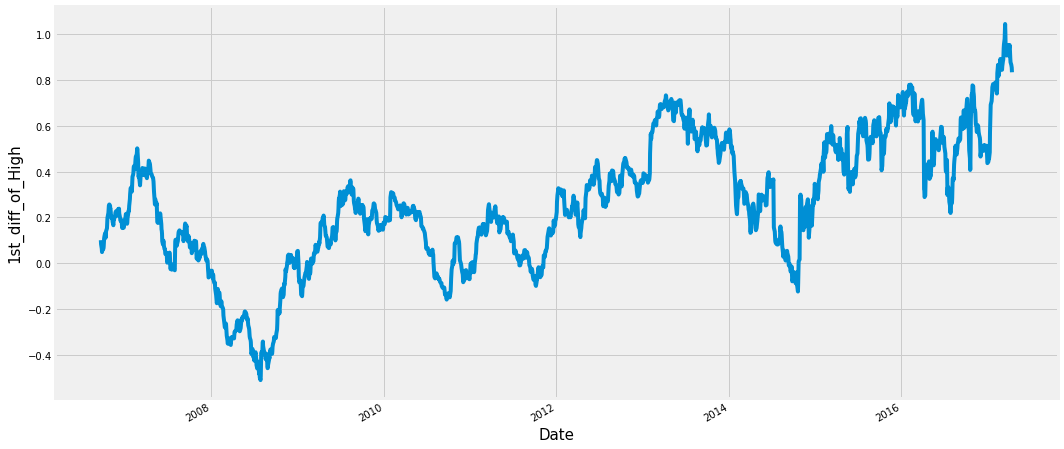

In [52]:
# 1차 차분
plt.figure(figsize = (16, 8))
decomposed_google_volume.trend.diff().plot()
plt.xlabel('Date', fontsize = 15)
plt.ylabel('1st_diff_of_High', fontsize = 15)

# Modeling using statstools

## AR models(자기회귀모형)
- **시계열 자료가 그 시계열 자료의 과거 값들로써 설명되는 모형**
    - 즉, **회귀모형에서 이야기하는 독립변수들이 그 시계열 자료의 과거 값들이라는 것!!**
- 과거 p기까지의 값들이 현재 시점의 시계열 값에 영향을 준다고 할 경우, **p차 자기회귀모형**이라고 하며 **AR(p)**이라고 표현한다. 

### Predicting humidity level of Montreal
- ARMA(1, 0) 모형을 사용하였다.
    - 즉, AR(1) 모형을 사용한 것과 동일!

In [53]:
humidity['Montreal'].diff().iloc[1:]

datetime
2012-10-01 14:00:00   -2.0
2012-10-01 15:00:00   -4.0
2012-10-01 16:00:00   -3.0
2012-10-01 17:00:00   -4.0
2012-10-01 18:00:00   -4.0
                      ... 
2017-11-29 20:00:00   -9.0
2017-11-29 21:00:00   -5.0
2017-11-29 22:00:00    7.0
2017-11-29 23:00:00   -8.0
2017-11-30 00:00:00    0.0
Name: Montreal, Length: 45251, dtype: float64

<Figure size 1152x576 with 0 Axes>

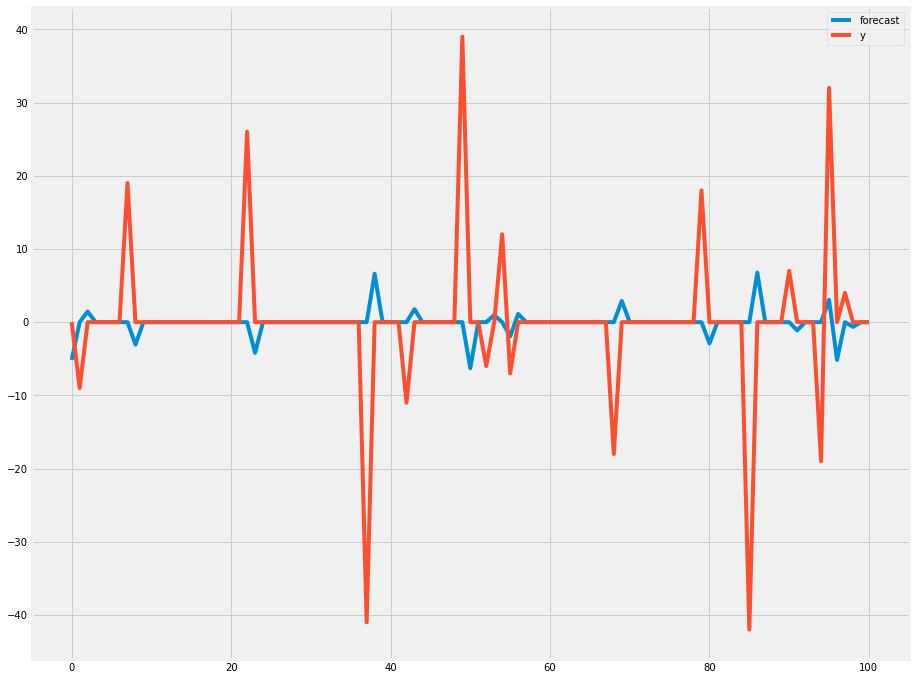

In [54]:
plt.figure(figsize = (16, 8))
humid = ARMA(humidity['Montreal'].diff().iloc[1:].values, order = (1, 0))
result1 = humid.fit()
result1.plot_predict(start = 1000, end = 1100)
plt.show()

In [55]:
# RMSE 계산
rmse = math.sqrt(mean_squared_error(humidity['Montreal'].diff().iloc[900:1000].values, result1.predict(start = 900, end = 999)))
print('The root mean squared error is {}'.format(rmse))

The root mean squared error is 8.029135153956044


### Predicting closing prices of google
- ARMA(1, 0) 모형을 사용하였다.
    - 즉, AR(1) 모형을 사용한 것과 동일!

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(1, 0)   Log Likelihood              -10114.496
Method:                       css-mle   S.D. of innovations              6.906
Date:                Thu, 20 Aug 2020   AIC                          20234.993
Time:                        19:56:14   BIC                          20253.030
Sample:                             0   HQIC                         20241.479
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2769      0.129      2.141      0.032       0.023       0.530
ar.L1.y        0.0280      0.018      1.541      0.123      -0.008       0.064
                                    Roots           

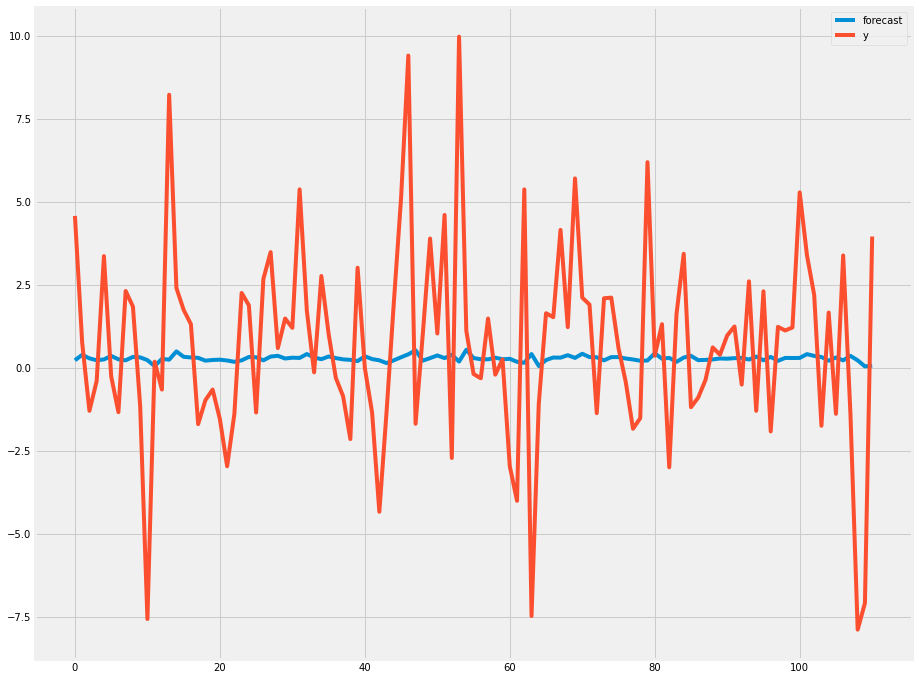

In [56]:
price = ARMA(google['Close'].diff().iloc[1:].values, order = (1, 0))
result2 = price.fit()

print(result2.summary())

result2.plot_predict(start = 900, end = 1010)
plt.show()

## MA models(이동평균모형)
- **이동평균모형(MA)**은 시계열자료가 과거의 오차값들로 표현될 수 있다.
    - 즉, 이동평균모형은 시계열자료가 연속적인 오차항들의 영향을 받으며, **q차 이동평균모형**을 **MA(q)**라고 표현한다. 

### Forecasting and predicting montreal humidity
- ARMA(0, 3) 모형을 사용하였다.
    - 즉, MA(3) 모형을 사용한 것과 동일!

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                45251
Model:                     ARMA(0, 3)   Log Likelihood             -153516.982
Method:                       css-mle   S.D. of innovations              7.197
Date:                Thu, 20 Aug 2020   AIC                         307043.965
Time:                        19:56:17   BIC                         307087.564
Sample:                             0   HQIC                        307057.686
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.031     -0.025      0.980      -0.061       0.060
ma.L1.y       -0.1621      0.005    -34.507      0.000      -0.171      -0.153
ma.L2.y        0.0386      0.005      8.316      0.0

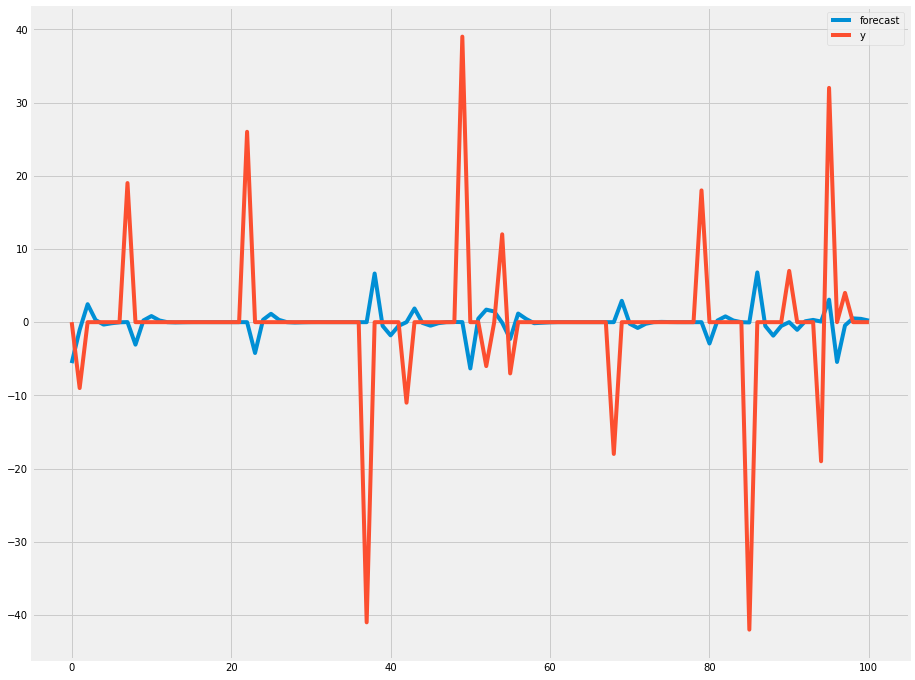

In [57]:
model = ARMA(humidity['Montreal'].diff().iloc[1:].values, order = (0, 3))
result = model.fit()

print(result.summary())
print("μ={} ,θ={}".format(result.params[0], result.params[1]))

result.plot_predict(start = 1000, end = 1100)
plt.show()

In [58]:
rmse = math.sqrt(mean_squared_error(humidity['Montreal'].diff().iloc[1000:1101].values, 
                                    result.predict(start = 1000, end = 1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 11.345129429209324.


## ARMA models(자기회귀이동평균모형)
- **자기회귀모형(AR)**은 시계열자료가 과거의 시계열자료 값들로 표현될 수 있다는 것이고, **이동평균모형(MA)**은 시계열자료가 과거의 오차값들로 표현될 수 있다.
- 그러나 경우에 따라서는 시계열자료가 과거의 시계열자료 값들과 과거의 오차값들 모두의 영향을 받는다고 할 수도 있을 것이다.
    - 이러한 경우에 사용하는 모형이 바로 **자기회귀이동평균모형(ARMA)**이다.
    - 즉, **AR 모형과 MA 모형이 혼합된 모형**이다.

### Forecasting and predicting microsoft stocks volume
- ARMA(3, 3) 모형을 사용하였다.

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(3, 3)   Log Likelihood              -55408.974
Method:                       css-mle   S.D. of innovations       22751607.974
Date:                Thu, 20 Aug 2020   AIC                         110833.948
Time:                        19:56:24   BIC                         110882.047
Sample:                             0   HQIC                        110851.244
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.03e+04   9915.350     -2.047      0.041   -3.97e+04    -863.493
ar.L1.y        0.2053      0.160      1.287      0.198      -0.107       0.518
ar.L2.y        0.7296      0.179      4.079      0.0

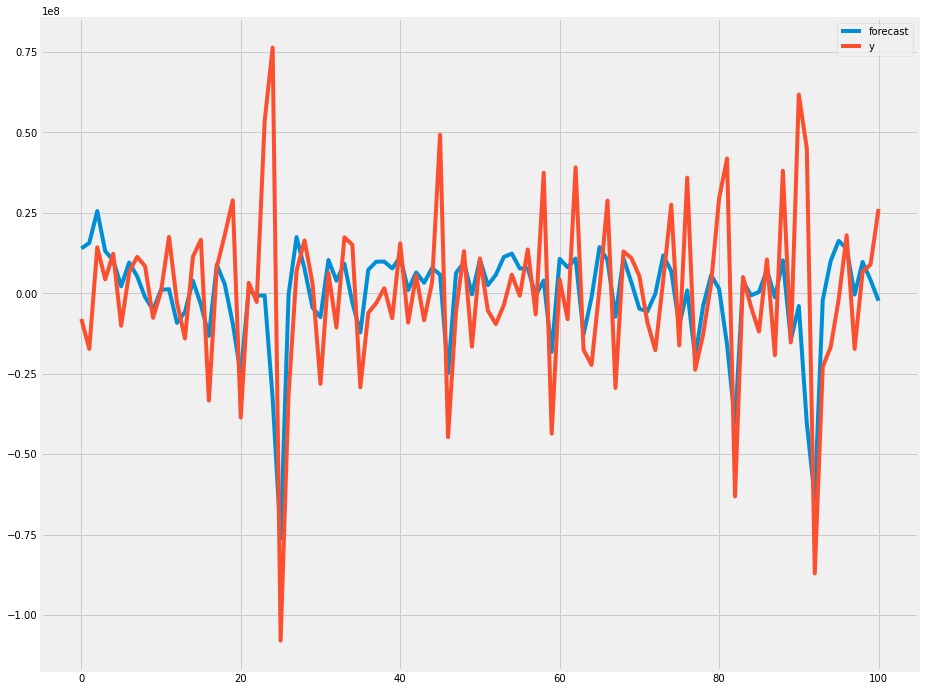

In [59]:
model = ARMA(microsoft['Volume'].diff().iloc[1:].values, order = (3, 3))
result = model.fit()

print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0], result.params[1], result.params[2]))

result.plot_predict(start = 1000, end = 1100)
plt.show()

In [60]:
rmse = math.sqrt(mean_squared_error(microsoft['Volume'].diff().iloc[1000:1101].values,
                                    result.predict(start = 1000, end = 1100)))
print('The root mean squared error is {}.'.format(rmse))

The root mean squared error is 38038300.60286924.


- 위 결과를 통해 알 수 있듯이, ARMA 모형이 AR 모형 및 MA 모형에 비해 훨씬 성능이 뛰어나다.

## ARIMA models
- 시계열자료를 분석하는데 직면하는 많은 자료들은 비정상 시계열자료이다.
- 따라서 비정상 시계열자료를 먼저 차분 등을 통하여 정상 시계열자료로 전환시켜야 하기 때문에, **비정상 시계열 모형인 ARIMA(p, d, q) 모형**을 사용한다.

### Predicting the microsoft stocks volume

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3017
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -56385.467
Method:                       css-mle   S.D. of innovations       31647215.007
Date:                Thu, 20 Aug 2020   AIC                         112778.933
Time:                        19:56:26   BIC                         112802.981
Sample:                             1   HQIC                        112787.581
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9984.0302   2.48e+05      0.040      0.968   -4.75e+05    4.95e+05
ar.L1.D.y     -0.8716      0.016    -53.758      0.000      -0.903      -0.840
ar.L2.D.y     -0.4551      0.016    -28.071      0.0

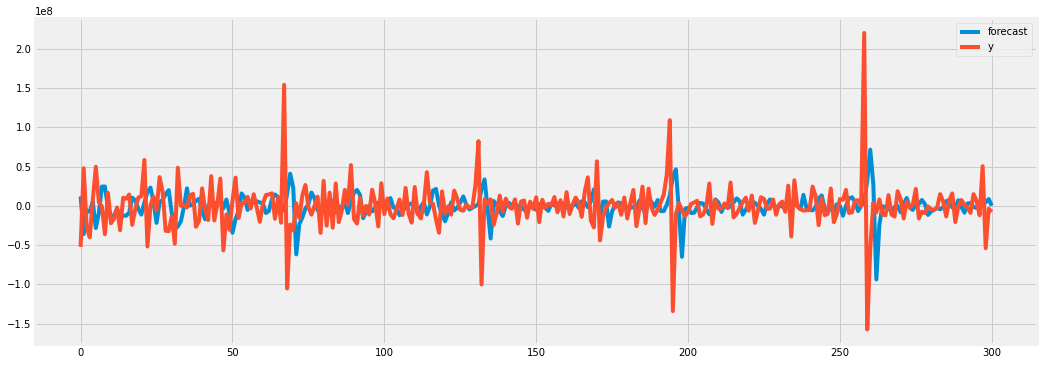

In [61]:
rcParams['figure.figsize'] = 16, 6

model = ARIMA(microsoft['Volume'].diff().iloc[1:].values, order = (2, 1, 0))
result = model.fit()

print(result.summary())

result.plot_predict(start = 700, end = 1000)
plt.show()

In [62]:
rmse = math.sqrt(mean_squared_error(microsoft['Volume'].diff().iloc[700:1001].values,
                                    result.predict(start = 700, end = 1000)))
print('The root mean squared error is {}.'.format(rmse))

The root mean squared error is 61937609.72627306.


- ARIMA 모형의 예측 결과를 살펴보니, 꽤 좋은 예측력을 보이는 것을 알 수 있다.